In [1]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
%matplotlib inline
plt.viridis()

In [2]:
no_iterations = 3000000

# Wiring
n = 16
N = n ** 2
S = (n, n)

s_max = 32
sigma_form_forward = 2.5
sigma_form_lateral = 1
p_form_lateral = 1
p_form_forward = 0.16
p_elim_dep = 0.0245
p_elim_pot = 1.36 * np.e ** -4
f_rew = 10 ** 4 * Hz#Hz

# Membrane
v_rest = -70 * mvolt #mV
e_ext = 0 * mvolt #V
v_thr = -54 * mvolt #mV
g_max = 0.2
tau_m = 20* ms #ms
tau_ex = 5* ms #ms
e = np.e
g = g_max
pre_t = 0 * ms


# Inputs
f_mean = 20 * Hz
f_base = 5 * Hz
f_peak = 152.8  * Hz
sigma_stim = 2
t_stim = 0.02 * second
rate = 200 * Hz

# STDP
Apre = a_plus = 0.1
b = 1.2
taupre = tau_plus = 20 * ms #ms
taupost = tau_minus = 64 * ms #ms
Apost = a_minus = (a_plus * tau_plus * b) / tau_minus

In [3]:
def distance(s, t, grid_size=S, dist_type='euclidian'):
    '''
    Function that computes distance in a grid of neurons taking into account periodic boundry conditions.
    
    First, translate source into the center of the grid.
    Second, translate target by the same amount.
    Finally, perform desired distance computation.
    '''
    s = np.asarray(s)
    t = np.asarray(t)
    _grid_size = np.asarray(grid_size)
    trans = s - (_grid_size//2)
    s = np.mod(s - trans, grid_size)
    t = np.mod(t - trans, grid_size)
    if dist_type == 'manhattan':
        return s[0] - t[0] + s[1] - t[1]
    return np.sqrt((s[0] - t[0])**2 + (s[1] - t[1])**2)

In [4]:
def generate_rates(s, grid_size=S, dist_type='euclidian'):
    '''
    Function that generates an array the same shape as the input layer so that 
    each cell has a value corresponding to the firing rate for the neuron
    at that position.
    '''
    _rates = np.zeros(S)
    for x, y in np.ndindex(S):
        _d = distance(s, (x,y), grid_size=grid_size, dist_type=dist_type)
        _rates[x, y] = f_base + f_peak * np.e ** (-_d/(2 * sigma_stim**2))
    return _rates * Hz

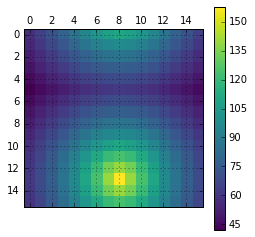

In [5]:
plt.matshow(generate_rates((13,8))/Hz, fignum=160)
plt.grid(visible=True)
plt.colorbar()

In [6]:
def potential_presynaptic_neuron(projection, postsynaptic_index, N=N):
    potential_neurons = np.nonzero(np.invert(projection.synapse_connected.reshape(N,N)[:, postsynaptic_index]))[0]
    if len(potential_neurons) == 0:
        return None
    random_index = potential_neurons[np.random.randint(0, len(potential_neurons))]
    return random_index

In [7]:
_sim_time = 5 * 60 * second
print "In the approximate simulated time of ", _sim_time, "rewiring would be triggered", _sim_time * f_rew, "times"

In the approximate simulated time of  300. s rewiring would be triggered 3000000.0 times


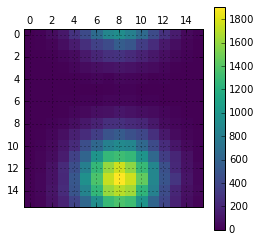

In [8]:
distro = np.zeros((16,16))
_location = (13,8)
_no_iter = int(_sim_time * f_rew)
for i in range(_no_iter):
    _random_index = np.random.randint(0, 16, 2)
    if np.random.rand() < p_form_forward * np.e ** (-(distance(_location, _random_index)**2)/(2*sigma_form_forward**2)):
        distro[_random_index[0], _random_index[1]] += 1

plt.matshow(distro, fignum=160)
plt.grid(visible=True)
plt.colorbar()

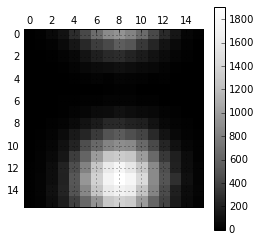

In [9]:
plt.matshow(distro,cmap='Greys_r', fignum=160)
plt.grid(visible=True)
plt.colorbar()

In [10]:
print "out of", _no_iter, "potential synapses,", np.sum(np.sum(distro, 1), 0), "projections have actually been created"
print "i.e.", np.sum(np.sum(distro, 1), 0) * 100. / _no_iter, "% of them"

out of 3000000 potential synapses, 73405.0 projections have actually been created
i.e. 2.44683333333 % of them


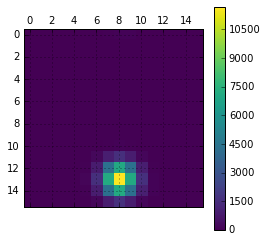

In [11]:
distro = np.zeros((16,16))
_location = (13,8)
_no_iter = int(_sim_time * f_rew)
for i in range(_no_iter):
    _random_index = np.random.randint(0, 16, 2)
    if np.random.rand() < p_form_lateral * np.e ** (-(distance(_location, _random_index)**2)/(2*sigma_form_lateral**2)):
        distro[_random_index[0], _random_index[1]] += 1

plt.matshow(distro, fignum=160)
plt.grid(visible=True)
plt.colorbar()

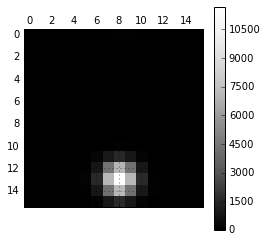

In [12]:
plt.matshow(distro,cmap='Greys_r', fignum=160)
plt.grid(visible=True)
plt.colorbar()

In [13]:
print "out of", _no_iter, "potential synapses,", np.sum(np.sum(distro, 1), 0), "projections have actually been created"
print "i.e.", np.sum(np.sum(distro, 1), 0) * 100. / _no_iter, "% of them"

out of 3000000 potential synapses, 73728.0 projections have actually been created
i.e. 2.4576 % of them


In [14]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

**Neuron dynamics (target-layer)**: the membrane voltage $V_{mem}$ is described by:

$\tau_{mem}\frac{\delta V_{mem}}{\delta t} = V_{rest} - V_{mem} + g_{ex}(t)(E_{ex}-V_{mem})$


$E_{ex}$ = excitatory reversal potential; $V_{rest}$ = resting potential; $\tau_{mem}$ = membrane time constant. Upon reaching a threshold $V_{thr}$, a spike occurs and $V_{mem}$ is reset to $V_{rest}$. A presynaptic
spike at time 0 causes a synaptic conductance at time $t \geq O$ of $g_{ex}(t) = ge^\frac{-t}{\tau_{ex}}(\tau_{ex}$= synaptic time constant); this is cumulative for all pre-synaptic spikes.

**STDP**: a pre-synaptic spike at time $t_{pre}$ and post-synaptic spike at $t_{post}$ modify the synaptic
conductance by $g —> g + g_{max}F(\Delta t)$,where $\Delta t = t_{pre}—t_{post}$ and $F(\Delta t) = A_{+}exp (\Delta t/T_{+})$ if
$\Delta t$ < 0, otherwise $F(\Delta t) = -A_{-}exp (-\Delta t/T_{-})$, where $A_{+/-}$ are magnitudes and 
$\tau_{+/-}$ are time constants for potentiation and depression respectively. This is cumulative for all pre and
post-synaptic spike pairs; g is bounded in (0, $g_{max}$).

In [15]:
import time
def simulate(n=n, N=N, duration=100*ms, dt=0.1 * ms, rate=200 * Hz):
    start = time.time() * second
    comp_s_max = np.ones(N) * s_max
    start_scope()
    projections = []
    layers = []
    neuron_dynamics = '''
    dv/dt = (v_rest-v + gex * (e_ext - v))/tau_m : volt
    dgex/dt = -gex/tau_ex: 1
    s : 1
    '''
    G = NeuronGroup(N, neuron_dynamics, threshold='v > -54 * mV',
                    reset='v = -70 * mV', method='euler', dt=0.1 * ms, name="target_layer")
    G.v   = [-70*mV,] * N
    G.gex = [0.0, ]   * N
    G.s   = [0, ]     * N
    layers.append(G)
    statemon = StateMonitor(G, ['v', ], record=True)
    spikemon = SpikeMonitor(G)



    # Pre pop
    location = np.random.randint(0,n, 2)
    rates = generate_rates(location)
    inp = NeuronGroup(N, 'rates : Hz', threshold='rand()<rates*dt', dt=0.1 * ms, name="source_layer")
    layers.append(inp)
    inp.rates = rates.ravel()
    
    synapse_model = '''
                     w : 1
                     dapre/dt = -apre/taupre : 1 (event-driven)
                     dapost/dt = -apost/taupost : 1 (event-driven)
                     '''
    on_pre_model = '''
                     gex_post += w
                     apre += Apre
                     w = clip(w+apost, 0, g_max)
                     '''
    on_post_model = '''
                     apost += Apost
                     w = clip(w+apre, 0, g_max)
                     '''
    
    # Feedforward connections (from source to target)
    feedforward = Synapses(inp, G, synapse_model, 
                     on_pre = on_pre_model,
                     on_post = on_post_model,
                     dt = dt, name="feedforward_projections")
    feedforward.connect()
    feedforward.add_attribute('synapse_connected')
    feedforward.synapse_connected = np.zeros(N**2, dtype=np.bool_)
    feedforward.w = [0, ] * (N**2)
    projections.append(feedforward)
    
    # Lateral connections (from target to target)
    
    lateral = Synapses(G, G, synapse_model, 
                     on_pre = on_pre_model,
                     on_post = on_post_model,
                     dt = dt, name="lateral_projections")
    lateral.connect()
    lateral.add_attribute('synapse_connected')
    lateral.synapse_connected = np.zeros(N**2, dtype=np.bool_)
    lateral.w = [0, ] * (N**2)
    projections.append(lateral)
    
    
    def elimination_rule(projection, synapse_index, N=N):
        '''
        Delete a synapse based on the elimination probability
        '''
        # Pre is the row index
        pre = synapse_index // N
        # Post is the column index
        post = synapse_index % N
        # Generate a value to check against form / elimination probabilities 
        r = np.random.rand()
        if (projection.w[synapse_index] <= .5 * g_max and r < p_elim_dep) or r < p_elim_pot:
            projection.w[synapse_index] = 0
            projection.synapse_connected[synapse_index] = False
            projection.target.s[post] -= 1
            
    
    def formation_rule(projection, synapse_index, N=N):
        '''
        Create a new synapse based on the formation probability
        Also, take into account the number of existing presynaptic projections into the current neuron
        '''
        # Pre is the row index
        pre = synapse_index // N
        # Post is the column index
        post = synapse_index % N
        # Generate a value to check against form / elimination probabilities 
        r = np.random.rand()        
        if 'feedforward' in projection.name and r < p_form_forward *\
                np.e **(-(distance((pre//n, pre%n), (post//n, post%n))**2)/(2*sigma_form_forward**2)):
            # Form synapse
            projection.w[synapse_index] = g_max
            projection.synapse_connected[synapse_index] = True
            projection.target.s[post] += 1
        elif 'lateral' in projection.name and r < p_form_lateral *\
                np.e **(-(distance((pre//n, pre%n), (post//n, post%n))**2)/(2*sigma_form_lateral**2)):
            # Form synapse
            projection.w[synapse_index] = g_max
            projection.synapse_connected[synapse_index] = True
            projection.target.s[post] += 1
            
    
#     inp_spikemon = SpikeMonitor(inp)
    @network_operation(dt=1./ f_rew)
    def rewire():
        '''
        At a fixed rate, a potential synapse is chosen. If it already exists, follow elimination rule, 
        else follow formation rule.
        
        '''
        # First, choose a type of projection (FF or LAT)
        projection_index = np.random.randint(0, len(projections))
        # Second, choose a postsynaptic neuron from that projection
        postsynaptic_neuron_index = np.random.randint(0, N)
        
        potential_pre = potential_presynaptic_neuron(projections[projection_index], postsynaptic_neuron_index, N=N)
        _2d_to_1d_arithmetic = potential_pre * N + postsynaptic_neuron_index
#         _2d_to_1d_arithmetic = pre_x * N + pre_y
        # Third, check if the synapse exists or not and follow the appropriate rule
        if projections[projection_index].synapse_connected[_2d_to_1d_arithmetic]:
            elimination_rule(projections[projection_index], _2d_to_1d_arithmetic)
        elif projections[projection_index].target.s[postsynaptic_neuron_index] < s_max:
            formation_rule(projections[projection_index], _2d_to_1d_arithmetic)
    
    @network_operation(dt=t_stim)
    def change_stimulus():
        location = np.random.randint(0,n, 2)
        rates = generate_rates(location)
        inp.rates = rates.ravel()

    # Initial synapses    
    for postsynaptic_neuron_index in range(N):
        # Place Feedforward first (S_max // 2)
        while G.s[postsynaptic_neuron_index] < s_max//2:
            potential_pre = potential_presynaptic_neuron(projections[0], postsynaptic_neuron_index, N=N)
            _2d_to_1d_arithmetic = potential_pre * N + postsynaptic_neuron_index
            formation_rule(projections[0], _2d_to_1d_arithmetic)
        
        # Place Lateral now (S_max // 2)
        while G.s[postsynaptic_neuron_index] < s_max:
            potential_pre = potential_presynaptic_neuron(projections[1], postsynaptic_neuron_index, N=N)
            _2d_to_1d_arithmetic = potential_pre * N + postsynaptic_neuron_index
            formation_rule(projections[1], _2d_to_1d_arithmetic)
    init_done = time.time() * second
    print "Initialization done in ", init_done - start
    print "Starting sim"    
    run(duration)
    print "Sim done"

    
    end = time.time() * second
    print "Simulation finished in", end - init_done
    output = (statemon, spikemon, feedforward, lateral)
    return output

In [48]:
state, spike, ff, lat = simulate(duration=100*ms)

Initialization done in  57.89899993 s
Starting sim


WARNING    "rates" is an internal variable of group "source_layer", but also exists in the run namespace with the value array([[  66.50485659,   59.50832653,   66.50485659,   74.30800846,
          82.9435055 ,   92.3665846 ,  102.36199771,  112.294403  ,
         120.54053024,  124.00075965,  120.54053024,  112.294403  ,
         102.36199771,   92.3665846 ,   82.9435055 ,   74.30800846],
       [  63.97763112,   57.51660517,   63.97763112,   71.06270622,
          78.71902374,   86.78794628,   94.90915672,  102.36199771,
         107.90900686,  110.0178018 ,  107.90900686,  102.36199771,
          94.90915672,   86.78794628,   78.71902374,   71.06270622],
       [  60.77622248,   54.95366561,   60.77622248,   67.03768716,
          73.63065817,   80.34089605,   86.78794628,   92.3665846 ,
          96.26265552,   97.6778848 ,   96.26265552,   92.3665846 ,
          86.78794628,   80.34089605,   73.63065817,   67.03768716],
       [  57.13514129,   51.98752943,   57.13514129,   62.561

BrianObjectException: Original error and traceback:
Traceback (most recent call last):
  File "c:\python27\lib\site-packages\brian2\core\network.py", line 686, in before_run
    obj.before_run(run_namespace)
  File "c:\python27\lib\site-packages\brian2\groups\group.py", line 1038, in before_run
    codeobj_class=self.codeobj_class
  File "c:\python27\lib\site-packages\brian2\codegen\codeobject.py", line 233, in create_runner_codeobj
    run_namespace=run_namespace)
  File "c:\python27\lib\site-packages\brian2\groups\group.py", line 706, in resolve_all
    run_namespace=run_namespace)
  File "c:\python27\lib\site-packages\brian2\groups\group.py", line 663, in _resolve
    return self._resolve_external(identifier, run_namespace=run_namespace)
  File "c:\python27\lib\site-packages\brian2\groups\group.py", line 774, in _resolve_external
    (identifier))
KeyError: 'The identifier "v_reset" could not be resolved.'

Error encountered with object named "target_layer_resetter".
Object was created here (most recent call only, full details in debug log):
  File "<ipython-input-47-b5660efefc87>", line 14, in simulate
    reset='v = v_reset', method='euler', dt=0.1 * ms, name="target_layer")

An error occurred when preparing an object. KeyError: 'The identifier "v_reset" could not be resolved.'
(See above for original error message and traceback.)

In [ ]:
#     print "Output spike times:"
plot(state.t/ms, state.v[0])
# for t in spike.spike_trains()[0]:
#     axvline(t/ms, ls=':', c='r', lw=1, alpha=.3)
#         print t,
#     print "Input spike times:"
#     for t in inp_spikemon.t:
#         axvline(t/ms, ls=':', c='y', lw=1)
#         print t,
xlabel('Time (ms)')
ylabel('v')
ylim([-.075, -.05])

In [118]:
214 * second / (3000 * ms)

71.33333333333333

In [119]:
15 * second / (100 * ms)

150.0

In [20]:
(spike.num_spikes/float(N)) / (3000 * ms)

9.96907552 * khertz

In [19]:
spike.num_spikes / 3

2552083

In [130]:
_d = spike.spike_trains()
_s_p_n = []
for _i in range(N):
    _r = _d[_i]
    _s_p_n.append(len(_r))

In [131]:
print N

256


In [133]:
np.mean(_s_p_n)

29921.19140625

In [134]:
np.std(_s_p_n)

1.6148977978376642

In [137]:
np.mean(_s_p_n / (3000*ms))

9.97373047 * khertz

In [24]:
no_iterations * (.1 * ms)

300. * second

In [25]:
len(np.nonzero(ff.w.variable.get_value())[0])

65536

In [26]:
ff.w

<feedforward_projections.w: array([ 0.2,  0.2,  0.2, ...,  0.2,  0.2,  0.2])>

NameError: name 'G' is not defined